In [2]:
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import gymnasium as gym

from classes.QLearningAgentClass import QLearningAgent
from envs.createEnvs import createNNEnv
from utilities.plots import create_dicts_Qlearning, create_grids, plot_string_policy

In [5]:
env = createNNEnv(shape="14x14")

Loading models...
Models loaded


In [6]:
# hyperparameters
learning_rate = 0.02
n_episodes = 20000
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2)  # reduce the exploration over time
final_epsilon = 0.1

agent = QLearningAgent(env=env, learning_rate=learning_rate, initial_epsilon=start_epsilon, epsilon_decay=epsilon_decay, final_epsilon=final_epsilon)

In [7]:
env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)

for episode in tqdm(range(n_episodes)):
    done = False
    obs, _ = env.reset()
    obs = tuple(obs)
    
    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, _, _ = env.step(action)
        next_obs = tuple(next_obs)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 20000/20000 [08:52<00:00, 37.55it/s] 


## Visualizing the training




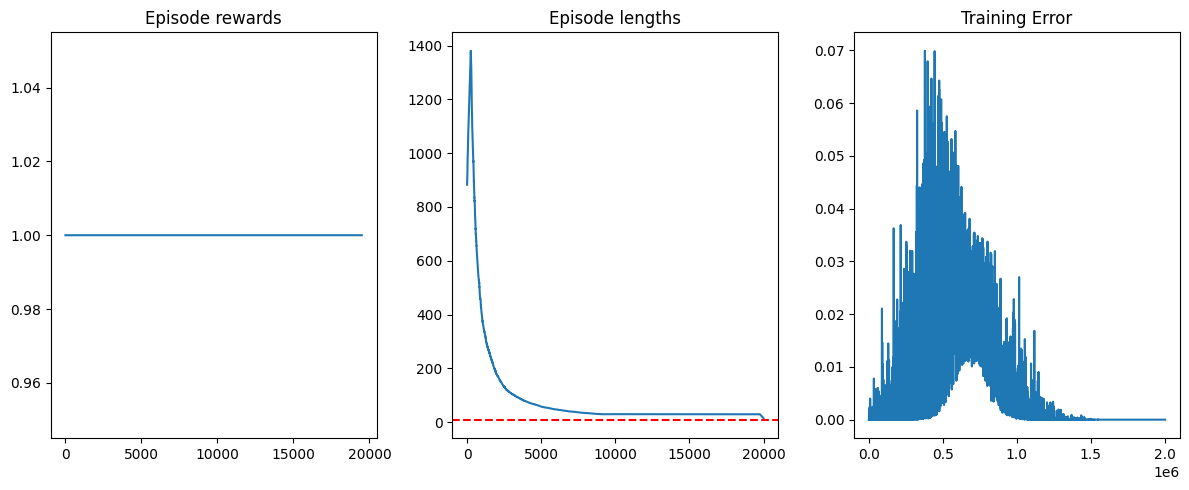

In [8]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (np.convolve(np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid") / rolling_length)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)

# Add a red line at y = 9 to the right plot
# Actually the value should be 8, but it depends if you consider reaching the goal as a step on its own or not
axs[1].axhline(y=9, color='red', linestyle='--', label='y=9')

axs[1].set_title("Episode lengths")
length_moving_average = (np.convolve(np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same") / rolling_length)
axs[1].plot(range(len(length_moving_average)), length_moving_average)

axs[2].set_title("Training Error")
training_error_moving_average = (np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

## Visualising the policy



c:\Users\el_sa\anaconda3\envs\TFG\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.maze to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.maze` for environment variables or `env.get_wrapper_attr('maze')` that will search the reminding wrappers.
  logger.warn(


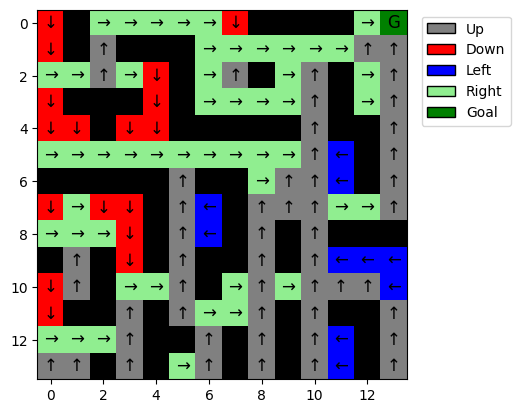

In [9]:
# state values & policy with usable ace (ace counts as 11)
state_value_dict, policy_dict = create_dicts_Qlearning(agent)
value_grid, policy_grid, string_policy_grid = create_grids(state_value_dict, policy_dict, env)
fig = plot_string_policy(string_policy_grid)
plt.show()